## Intro
Original GAN paper by Goodfellow et al.: https://arxiv.org/pdf/1406.2661.pdf  
Both generator and discriminator will be standard multilayer perceptrons (no convolutions just yet).

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

def mnist_std_mean():
    dataset = datasets.MNIST(root="./datasets", train=True, download=True)
    return torch.std_mean(dataset.data / 255.0)

t = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize(0.5, 0.5)])

mnist_train = datasets.MNIST(root="./datasets", train=True, download=True, transform=t)
mnist_test = datasets.MNIST(root="./datasets", train=False, download=True, transform=t)

## Generator

In [ ]:
class MnistGenerator(torch.nn.Module):
    def __init__(self, optim, nodim = 10, **kwargs):
        super(MnistGenerator, self).__init__()
        self.nodim = nodim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.nodim, 256),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(256, 512),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(1024, 784),
            torch.nn.Tanh()
        )
        self.optim = optim(self.parameters(), **kwargs)
        
    def forward(self, z):
        return self.model(z)
    
    #def loss(self, z):
        # converges super slow, seems like it makes no progress whatsoever
        #return torch.mean(1 - self.disc(self(z)), dim=0)
    
        # this should be better (according to the paper)
        # "-logD trick"
        #return -torch.mean(torch.log(self.disc(self(z))), dim=0)

    def update(self, dis, z):
        self.optim.zero_grad()
        l = dis.loss(dis(self(z)), torch.ones(z.shape[0], 1))
        l.backward()
        self.optim.step()
        return l

## Discriminator

In [ ]:
class MnistDiscriminator(torch.nn.Module):
    def __init__(self, criterion, optim, **kwargs):
        super(MnistDiscriminator, self).__init__()
        self.criterion = criterion
        self.model = torch.nn.Sequential(
            torch.nn.Linear(784, 1024),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),
            
            torch.nn.Linear(1024, 512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),
            
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),
            
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )
        self.optim = optim(self.parameters(), **kwargs)
    
    def forward(self, x: torch.Tensor):
        return self.model(x)
    
    def loss(self, x, label):
        return self.criterion(x, label)
        #return -torch.mean(label*torch.log(self(x)) + (1 - label)*torch.log(1 - self(self.gen(z))), dim=0)
    
    def update(self, true_sample, gen_sample):
        self.optim.zero_grad()
        true_loss = self.loss(self(true_sample), torch.ones(true_sample.shape[0], 1))
        true_loss.backward()
        
        prob = self(gen_sample.detach())
        false_loss = self.loss(prob, torch.zeros(true_sample.shape[0], 1))
        false_loss.backward()
        
        self.optim.step()
        return true_loss + false_loss, prob

## Training loop

In [4]:
def gen_noise(batch_size, dim):
    return torch.randn(batch_size, dim)

def save_examples(gen, n, **kwargs):
    noise = gen_noise(n, gen.nodim)
    examples = gen(noise)
    torchvision.utils.save_image((0.5*examples.reshape(n, 1, 28, 28)+0.5).detach(), **kwargs)

In [15]:
from tqdm.notebook import tqdm

def train(gen, dis, trainloader, epochs, k=1, k2=1):
    stats = {'dis': {
        'losses': [],
        'probs': []
    }, 'gen': {
        'losses': [] 
    }}
    gen.model.train()
    dis.model.train()
    
    for i in range(epochs):
        pbar = tqdm(enumerate(iter(trainloader)), total=len(trainloader))
        pbar.set_description("epoch %s/%s" % (i, epochs))
        for j, (images, labels) in pbar:
            dloss, pr = 0, 0
            for _ in range(k):
                unwrapped = images[:,0,:,:].reshape(trainloader.batch_size, 784)
                noise = gen_noise(trainloader.batch_size, gen.nodim)

                l, p = dis.update(unwrapped, gen(noise))
                dloss += l
                pr += p

            gloss = 0
            for _ in range(k2):
                noise = gen_noise(trainloader.batch_size, gen.nodim)
                gloss += gen.update(dis, noise)

            batch_prob = float(torch.mean(pr) / k)
            batch_dloss = float(torch.mean(dloss) / (2*k))
            batch_gloss = float(torch.mean(gloss) / k2)
            stats['gen']['losses'].append(batch_gloss)
            stats['dis']['probs'].append(batch_prob)
            stats['dis']['losses'].append(batch_dloss)
            if j % 20 == 0:
                pbar.write("D(G(z)): %.2f, generator loss: %.2f, discriminator loss: %.2f" % 
                           (float(batch_prob), float(batch_gloss), float(batch_dloss)), end="\r")
        save_examples(gen, n=30, fp="images/%d.png" % i, nrow=10, padding=0)
    gen.model.eval()
    dis.model.eval()
    return stats

## Training

In [16]:
NOISE_DIM = 100
EPOCHS = 50
BATCH_SIZE = 128
DIS_REPEAT = 1
GEN_REPEAT = 1
LR = 0.0002

In [17]:
gen = MnistGenerator(nodim=NOISE_DIM, optim=torch.optim.Adam, lr=LR)
dis = MnistDiscriminator(criterion=torch.nn.BCELoss(), optim=torch.optim.Adam, lr=LR)

mnist_trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)

stats = train(gen, dis, mnist_trainloader, epochs=EPOCHS, k=DIS_REPEAT, k2=GEN_REPEAT)

D(G(z)): 0.03, generator loss: 6.23, discriminator loss: 0.02


D(G(z)): 0.04, generator loss: 10.09, discriminator loss: 0.05


D(G(z)): 0.23, generator loss: 3.32, discriminator loss: 0.26


D(G(z)): 0.12, generator loss: 3.47, discriminator loss: 0.26


D(G(z)): 0.16, generator loss: 3.27, discriminator loss: 0.20


D(G(z)): 0.22, generator loss: 3.04, discriminator loss: 0.18


D(G(z)): 0.22, generator loss: 3.99, discriminator loss: 0.28


D(G(z)): 0.15, generator loss: 1.80, discriminator loss: 0.42


D(G(z)): 0.09, generator loss: 2.96, discriminator loss: 0.16


D(G(z)): 0.21, generator loss: 2.97, discriminator loss: 0.25


D(G(z)): 0.11, generator loss: 3.15, discriminator loss: 0.15


D(G(z)): 0.19, generator loss: 2.58, discriminator loss: 0.29


D(G(z)): 0.18, generator loss: 2.03, discriminator loss: 0.26


D(G(z)): 0.31, generator loss: 2.37, discriminator loss: 0.40


D(G(z)): 0.09, generator loss: 2.60, discriminator loss: 0.44


D(G(z)): 0.18, generator loss: 2.43, discriminator loss: 0.25


D(G(z)): 0.25, generator loss: 2.26, discriminator loss: 0.46


D(G(z)): 0.14, generator loss: 2.40, discriminator loss: 0.29


D(G(z)): 0.17, generator loss: 2.15, discriminator loss: 0.25


D(G(z)): 0.17, generator loss: 2.40, discriminator loss: 0.26


D(G(z)): 0.19, generator loss: 2.13, discriminator loss: 0.41


D(G(z)): 0.30, generator loss: 2.00, discriminator loss: 0.52


D(G(z)): 0.20, generator loss: 2.30, discriminator loss: 0.33


D(G(z)): 0.31, generator loss: 1.64, discriminator loss: 0.44


D(G(z)): 0.31, generator loss: 1.50, discriminator loss: 0.44


D(G(z)): 0.19, generator loss: 2.16, discriminator loss: 0.39


D(G(z)): 0.40, generator loss: 1.54, discriminator loss: 0.55


D(G(z)): 0.34, generator loss: 1.36, discriminator loss: 0.48


D(G(z)): 0.26, generator loss: 1.32, discriminator loss: 0.47


D(G(z)): 0.36, generator loss: 1.40, discriminator loss: 0.44


D(G(z)): 0.30, generator loss: 1.33, discriminator loss: 0.45


D(G(z)): 0.24, generator loss: 1.80, discriminator loss: 0.35


D(G(z)): 0.28, generator loss: 1.61, discriminator loss: 0.41


D(G(z)): 0.33, generator loss: 1.53, discriminator loss: 0.50


D(G(z)): 0.32, generator loss: 1.45, discriminator loss: 0.56


D(G(z)): 0.39, generator loss: 1.30, discriminator loss: 0.49


D(G(z)): 0.35, generator loss: 1.53, discriminator loss: 0.47


D(G(z)): 0.40, generator loss: 1.16, discriminator loss: 0.57


D(G(z)): 0.25, generator loss: 1.82, discriminator loss: 0.46


D(G(z)): 0.36, generator loss: 1.22, discriminator loss: 0.52


D(G(z)): 0.28, generator loss: 1.44, discriminator loss: 0.53


D(G(z)): 0.33, generator loss: 1.55, discriminator loss: 0.49


D(G(z)): 0.27, generator loss: 1.60, discriminator loss: 0.45


D(G(z)): 0.28, generator loss: 1.31, discriminator loss: 0.49


D(G(z)): 0.39, generator loss: 1.05, discriminator loss: 0.55


D(G(z)): 0.42, generator loss: 0.88, discriminator loss: 0.64


D(G(z)): 0.35, generator loss: 1.13, discriminator loss: 0.50


D(G(z)): 0.31, generator loss: 1.32, discriminator loss: 0.55


D(G(z)): 0.35, generator loss: 1.15, discriminator loss: 0.62


D(G(z)): 0.28, generator loss: 1.41, discriminator loss: 0.43


Text(0, 0.5, 'loss')

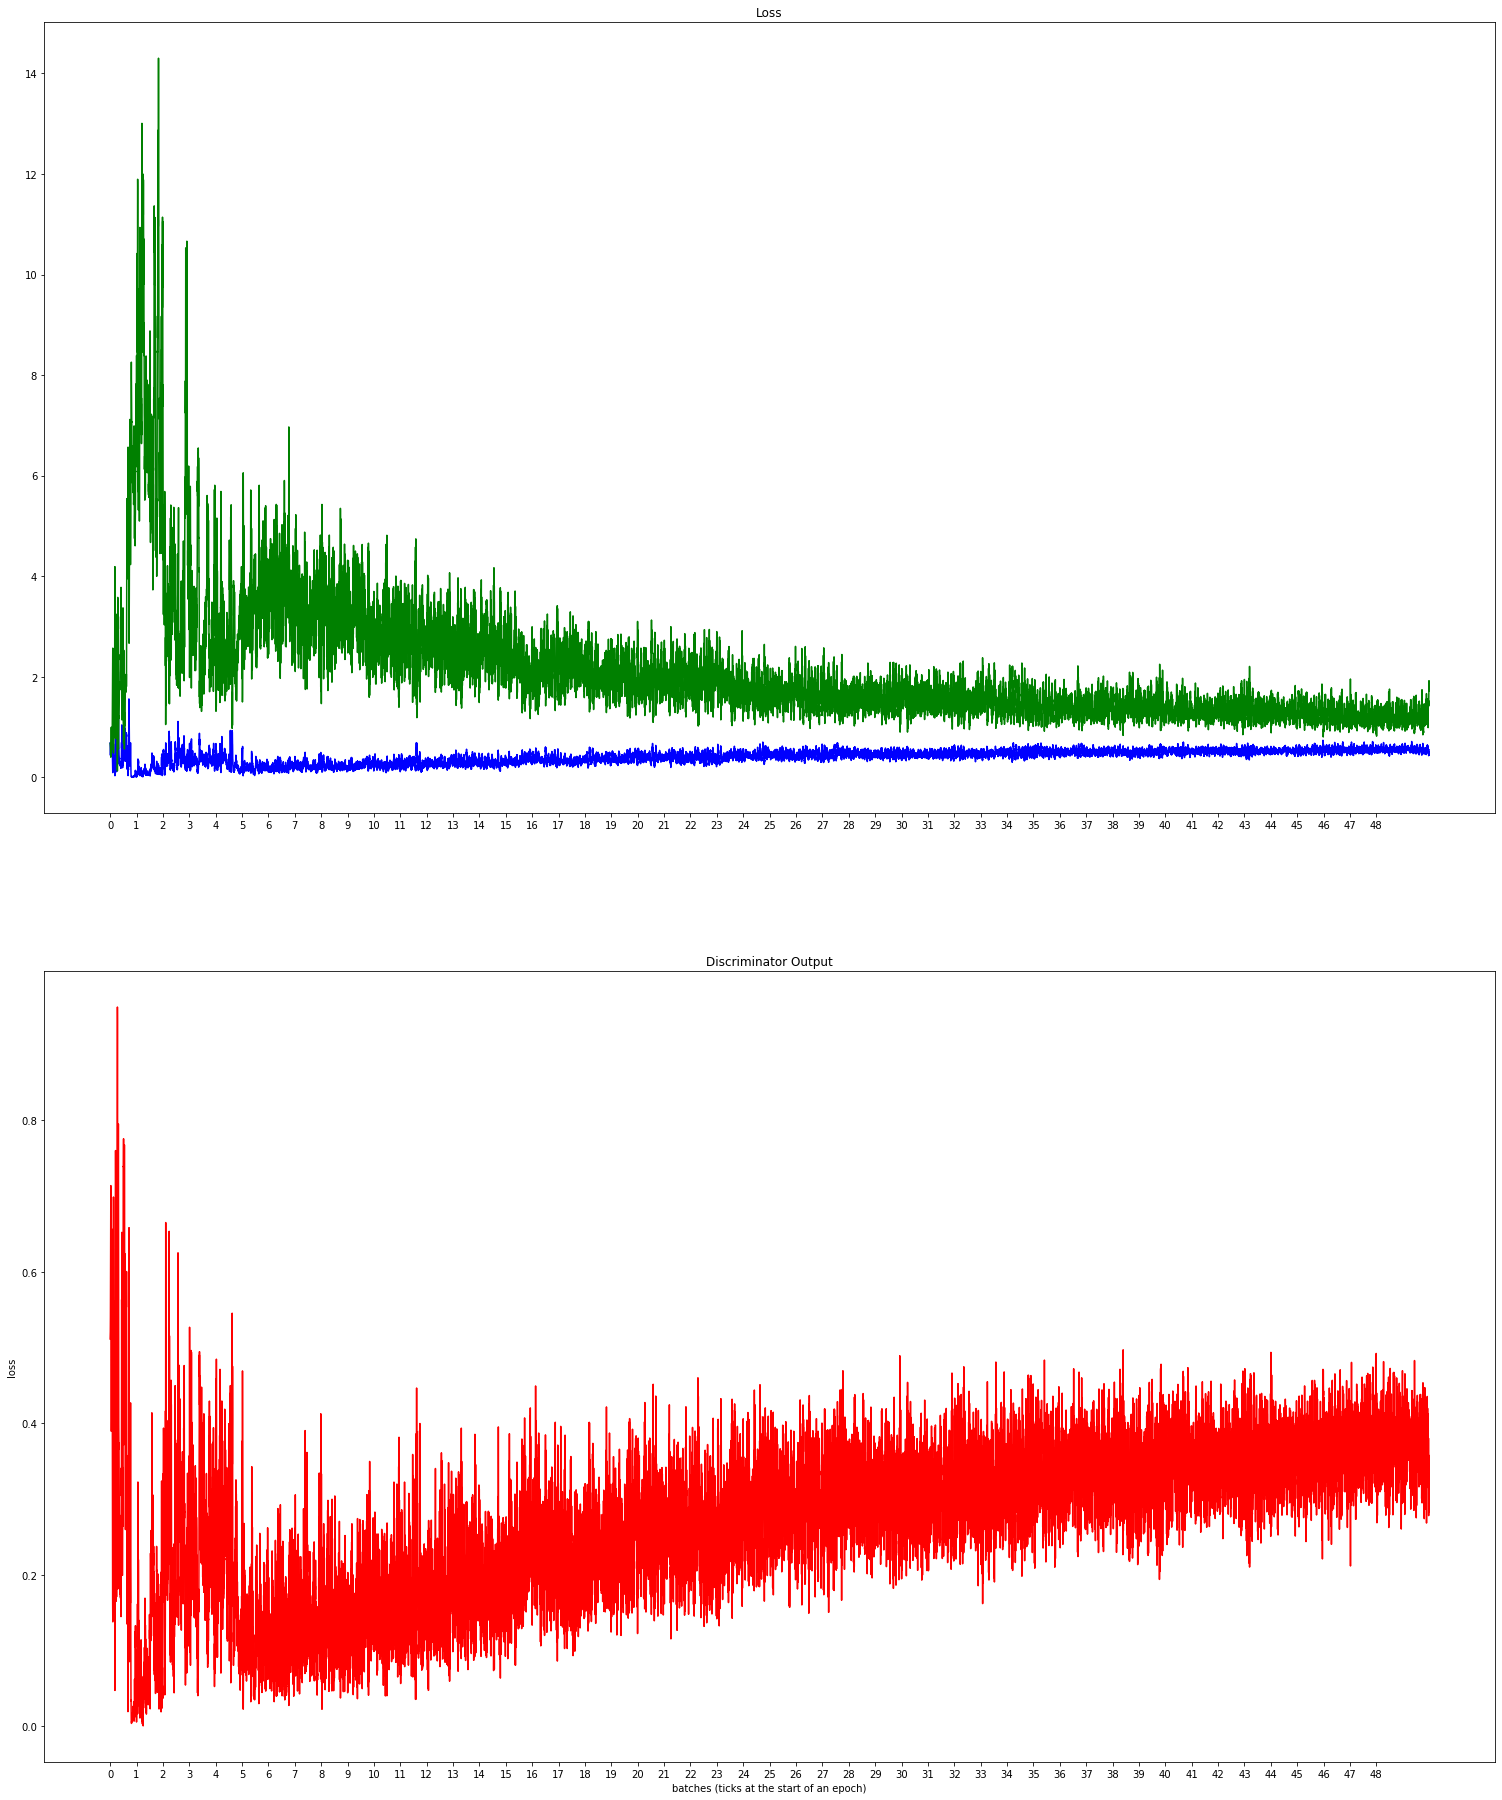

In [42]:
fig, (p1, p2) = plt.subplots(2, 1, figsize=(26,32))
p1.plot(range(EPOCHS * len(mnist_trainloader)), stats["dis"]["losses"], color="blue")
p1.set_title("Loss")
p1.plot(range(EPOCHS * len(mnist_trainloader)), stats["gen"]["losses"], color="green")
#p2.set_title("Generator Loss")
p2.plot(range(EPOCHS * len(mnist_trainloader)), stats["dis"]["probs"], color="red")

real_epochs = int(len(stats["gen"]["losses"]) / len(mnist_trainloader) - 1)
ticks = range(0, real_epochs * len(mnist_trainloader), len(mnist_trainloader))

p1.set_xticks(ticks)
p1.set_xticklabels(range(0, real_epochs))
p2.set_title("Discriminator Output")
p2.set_xticks(ticks)
p2.set_xticklabels(range(0, real_epochs))
plt.xlabel("batches (ticks at the start of an epoch)")
plt.ylabel("loss")

In [27]:
import imageio
with imageio.get_writer('images/result.gif', mode='I', duration=0.5) as writer:
    for filename in ["images/%s.png" % i for i in range(EPOCHS)]:
        image = imageio.imread(filename)
        writer.append_data(image)

## Save model

In [28]:
torch.save({
            'epoch': EPOCHS,
            'dis_state_dict': dis.state_dict(),
            'dis_optim_state_dict': dis.optim.state_dict(),
            'gen_state_dict': gen.state_dict(),
            'gen_optim_state_dict': gen.optim.state_dict(),
            'stats': stats
            }, 'models/pc_working_50epochs')

## Testing

In [ ]:
mnist_testloader = torch.utils.data.DataLoader(mnist_test, batch_size=16, shuffle=True, num_workers=0)
testiter = iter(mnist_testloader)
img, label = testiter.next()

fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(0.5*img + 0.5).detach().numpy().transpose(1, 2, 0), cmap="gray")

print(dis(img[:,0,:,:].reshape(16, 1, 784)).T)

tensor([[0.0588, 0.1987, 0.1478, 0.3291, 0.3405, 0.2643, 0.8342, 0.2131, 0.2282,
         0.6147, 0.1282, 0.1911, 0.2305, 0.0549, 0.2410, 0.4300, 0.2511, 0.1169,
         0.2508, 0.1321, 0.0265, 0.3259, 0.0890, 0.5013, 0.2390, 0.4006, 0.6044,
         0.1714, 0.4060, 0.2254, 0.2248, 0.1303, 0.2463, 0.0617, 0.0926, 0.0985,
         0.6065, 0.3622, 0.1837, 0.6935, 0.0701, 0.6466, 0.2430, 0.1968, 0.2640,
         0.5334, 0.0938, 0.5205, 0.0620, 0.4688, 0.0353, 0.1737, 0.2093, 0.0236,
         0.2151, 0.3201]], grad_fn=<PermuteBackward>)


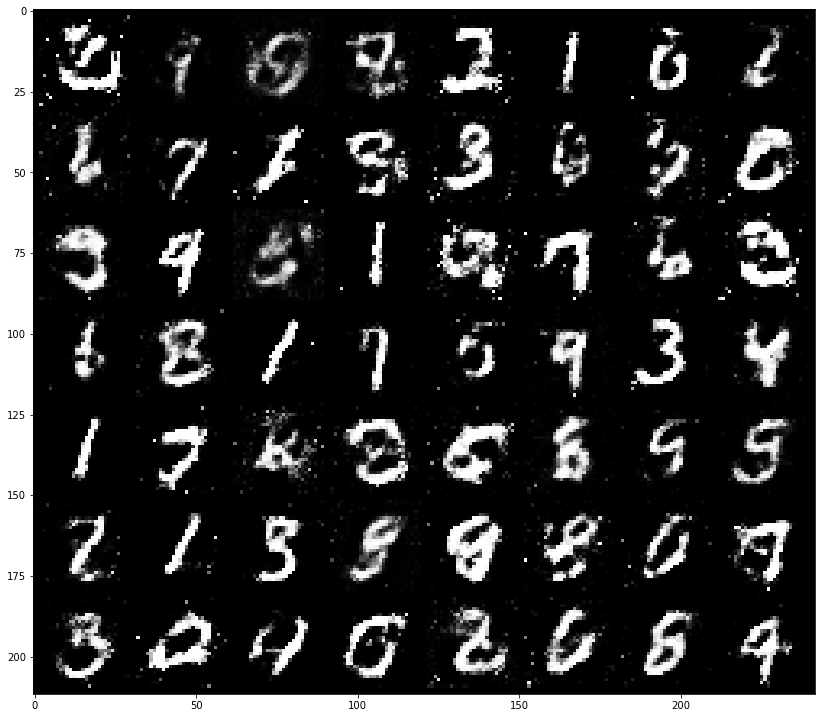

In [30]:
SAMPLE_SIZE = 56
noise = gen_noise(SAMPLE_SIZE, gen.nodim)
test = gen(noise)
fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(torchvision.utils.make_grid(0.5*test.reshape(SAMPLE_SIZE, 1, 28, 28) + 0.5).detach().numpy().transpose(1, 2, 0), cmap="gray")

print(dis(test).T)

## Links
- Goodfellow's NIPS Tutorial on GANS:
    - https://arxiv.org/abs/1701.00160
    - https://www.youtube.com/watch?v=HGYYEUSm-0Q
    
Good articles:
- http://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
- https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/
- https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/
- https://ai.stackexchange.com/questions/3488/understanding-gan-loss-function
- https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b

Other articles where they recreate GANs:
- https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/
= https://www.bigrabbitdata.com/pytorch-gan-1-generate-mnist-number-with-generative-adversarial-networkgans/#Load_Training_Dataset
- https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0

### To read
- https://rl-book.com/learn/statistics/kl_divergence/
- https://colah.github.io/posts/2015-09-Visual-Information/
- https://homes.cs.washington.edu/~ewein/blog/2020/07/14/entropy/ (discussion: https://news.ycombinator.com/item?id=23873752)
- https://longintuition.com/2020/07/20/max-entropy-intuition.html (discussion: https://news.ycombinator.com/item?id=23902712)
- https://arxiv.org/abs/1404.2000 (title: Notes on Kullback-Leibler Divergence and Likelihood)